<a href="https://colab.research.google.com/github/Rtniewi/kcwiertniewicz-IDS/blob/main/Assignment3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//***Katrina Cwiertniewicz
//*** CSC 330
//10/--/2024
//Assignment 3: VAE on the SVHN Dataset
####The purpose of this assignment is to create and train a Variational Autoencoder model in Keras to learn representations of the Street View House Numbers dataset and explore its performance with different latent dimensions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
EPOCHS = 50
BETA = 500

# Task 1: Load and Preprocess the SVHN Dataset

In [3]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-10 03:21:58--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  1.02MB/s    in 88s     

2024-10-10 03:23:26 (1.97 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-10 03:23:26--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  1.07MB/s    in 44s     

2024-10-10 03:24:10 (1.40 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [4]:
from scipy.io import loadmat

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')



Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


# Task 2: Build a Variational Autoencoder

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def build_vae(latent_dim):
  # Encoder
  encoder_input = layers.Input(
      shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input"
  )
  x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
      encoder_input
  )
  x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
  shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

  x = layers.Flatten()(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()

  # Decoder

  decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
  x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
  x = layers.Reshape(shape_before_flattening)(x)
  x = layers.Conv2DTranspose(
      128, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      64, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      32, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  decoder_output = layers.Conv2D(
      3,
      (3, 3),
      strides=1,
      activation="sigmoid",
      padding="same",
      name="decoder_output",
  )(x)

  decoder = models.Model(decoder_input, decoder_output)
  decoder.summary()

  # Create a variational autoencoder
  vae = VAE(encoder, decoder)
  return vae

In [7]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


# 3. Train the VAE with different Latent Dimensions

In [8]:
def main():
  latent_dims = [2,5,10]
  global vae
  for dim in latent_dims:
      print(f'Training VAE with latent dimension: {dim}')
      vae = build_vae(latent_dim=dim)
      vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
      vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, x_test))

main()

Training VAE with latent dimension: 2


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,444 (396.27 KB)

 Trainable params: 101,444 (396.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - kl_loss: 1.9763 - reconstruction_loss: 326.2437 - total_loss: 328.2198 - val_kl_loss: 3.0574 - val_loss: 316.4383 - val_reconstruction_loss: 313.3809
Epoch 2/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 2.7984 - reconstruction_loss: 318.1938 - total_loss: 320.9922 - val_kl_loss: 3.0117 - val_loss: 316.4566 - val_reconstruction_loss: 313.4449
Epoch 3/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - kl_loss: 2.8274 - reconstruction_loss: 318.0840 - total_loss: 320.9114 - val_kl_loss: 3.0510 - val_loss: 316.3835 - val_reconstruction_loss: 313.3324
Epoch 4/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - kl_loss: 2.8202 - reconstruction_loss: 318.2752 - total_loss: 321.0953 - val_kl_loss: 2.9945 - val_loss: 316.0905 - val_reconstruction_loss: 313.0960
Epoch 5/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 2.8414 - reconstruction_loss: 318.0961 - total_loss: 320.9374 - val_kl_loss: 3.1340 - val_loss: 316.3820 - 

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2048)           │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 5)              │         10,245 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 5)              │         10,245 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 5)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │          12,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,995 (988.26 KB)

 Trainable params: 252,995 (988.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - kl_loss: 2.5329 - reconstruction_loss: 325.2018 - total_loss: 327.7348 - val_kl_loss: 4.1963 - val_loss: 315.1310 - val_reconstruction_loss: 310.9346
Epoch 2/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - kl_loss: 4.1458 - reconstruction_loss: 315.4638 - total_loss: 319.6097 - val_kl_loss: 4.3443 - val_loss: 314.8734 - val_reconstruction_loss: 310.5292
Epoch 3/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 4.3219 - reconstruction_loss: 314.9814 - total_loss: 319.3032 - val_kl_loss: 4.7813 - val_loss: 313.9390 - val_reconstruction_loss: 309.1577
Epoch 4/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - kl_loss: 4.4330 - reconstruction_loss: 314.8584 - total_loss: 319.2914 - val_kl_loss: 4.5873 - val_loss: 314.2267 - val_reconstruction_loss: 309.6393
Epoch 5/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - kl_loss: 4.4524 - reconstruction_loss: 314.6265 - total_loss: 319.0789 - val_kl_loss: 4.8667 - val_loss: 313.5808 - va

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2048)           │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │         20,490 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │         20,490 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 134,228 (524.33 KB)

 Trainable params: 134,228 (524.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │          22,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,235 (1.00 MB)

 Trainable params: 263,235 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - kl_loss: 2.3412 - reconstruction_loss: 327.8691 - total_loss: 330.2104 - val_kl_loss: 4.3715 - val_loss: 315.6095 - val_reconstruction_loss: 311.2381
Epoch 2/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 4.4639 - reconstruction_loss: 315.0102 - total_loss: 319.4743 - val_kl_loss: 5.0143 - val_loss: 313.6906 - val_reconstruction_loss: 308.6764
Epoch 3/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - kl_loss: 4.8821 - reconstruction_loss: 314.3496 - total_loss: 319.2315 - val_kl_loss: 5.4964 - val_loss: 313.5910 - val_reconstruction_loss: 308.0946
Epoch 4/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - kl_loss: 5.0123 - reconstruction_loss: 314.2473 - total_loss: 319.2598 - val_kl_loss: 5.7233 - val_loss: 313.1358 - val_reconstruction_loss: 307.4125
Epoch 5/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - kl_loss: 5.0518 - reconstruction_loss: 313.8105 - total_loss: 318.8622 - val_kl_loss: 5.6948 - val_loss: 313.6714 - v

Task 4: Visualize the Results

# Reconstruct using the variational autoencoder

In [20]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [10]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Examples of real house numbers")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Examples of real house numbers


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.2788207 , 0.27944717, 0.30287537],
         [0.27286822, 0.28118852, 0.3029419 ],
         [0.26814052, 0.27508593, 0.3000869 ],
         ...,
         [0.21508078, 0.22055887, 0.24254845],
         [0.21861288, 0.22113906, 0.24423632],
         [0.23079027, 0.23046568, 0.25374615]],

        [[0.2785543 , 0.28025448, 0.30140278],
         [0.27009088, 0.27882493, 0.2986922 ],
         [0.268412  , 0.27620205, 0.29611284],
         ...,
         [0.20714286, 0.21159092, 0.23777962],
         [0.21378084, 0.21623173, 0.23869671],
         [0.21965958, 0.21836856, 0.23762114]],

        [[0.2783314 , 0.2833211 , 0.30492756],
         [0.27380228, 0.28287295, 0.30255333],
         [0.2691026 , 0.27490625, 0.29573074],
         ...,
         [0.20447928, 0.2066121 , 0.23699734],
         [0.21338291, 0.2136412 , 0.23937017],
         [0.2274424 , 0.22454575, 0.24313577]],

        ...,

        [[0.29814348, 0.31026435, 0.3271589 ],
         [0.29533064, 0.30727524, 0.32263818]

# Embed using the encoder

In [11]:
# Encode the example images
z_mean, z_var, z = vae.encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [12]:
# Some examples of the embeddings
print(z[:10])

[[ 7.8676164e-02 -1.6928871e+00 -3.3225119e-01  1.5721617e+00
  -5.4553008e-01 -8.5937852e-01  1.6462483e+00 -4.0971529e-01
  -4.9511796e-01  1.2335175e-01]
 [ 1.5074345e-01  8.8599885e-01  1.5285373e-02 -9.0432781e-01
  -8.9121515e-01  4.2209965e-01 -9.8346490e-01  2.2245902e-01
   7.7754349e-02  2.5327510e-01]
 [-5.4756165e-01  1.8305336e-01  3.5190251e-01 -7.8055048e-01
  -3.7874562e-01 -2.4979714e-01  1.0813066e-01 -1.4007628e+00
   1.0134563e+00 -1.1418905e+00]
 [ 6.1274004e-01 -6.2628967e-01 -1.5560742e-01 -9.7141373e-01
   4.6446520e-01  8.4095842e-01 -2.1201532e-01  2.1357237e-01
  -1.9948890e+00  2.7079442e-01]
 [ 1.5672503e-01 -3.5381615e-01  2.0788515e+00 -9.5029759e-01
  -4.1304410e-02  1.7775803e+00 -7.0431387e-01  1.0895512e+00
  -7.2977424e-01 -9.6315014e-01]
 [ 3.7162679e-01 -1.0094223e+00 -1.5228348e+00  3.6467451e-01
  -9.4480664e-01  5.8723897e-01  3.3310071e-01 -1.3380682e-01
  -7.6985693e-01  5.4444653e-01]
 [-3.4781063e-01 -2.7782544e-01  6.1046410e-01  2.8598843e

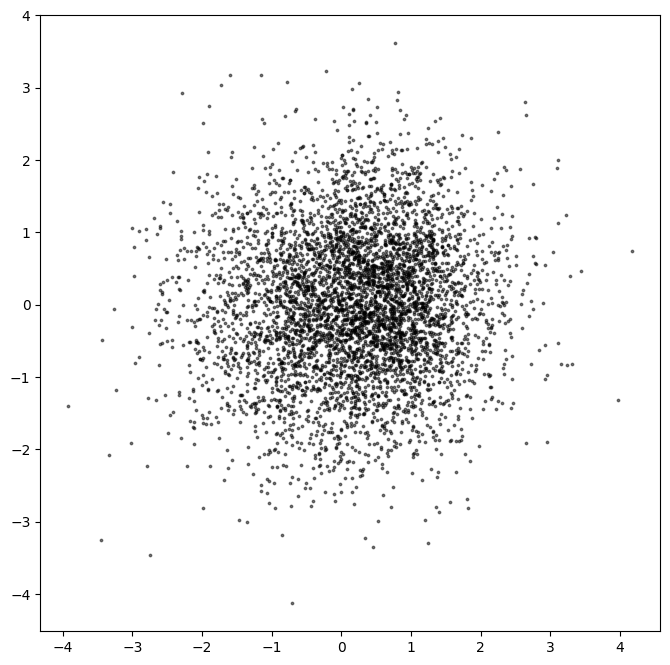

In [13]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Generate using the decoder

In [14]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 10))

In [15]:
# Decode the sampled points
reconstructions = vae.decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


In [16]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

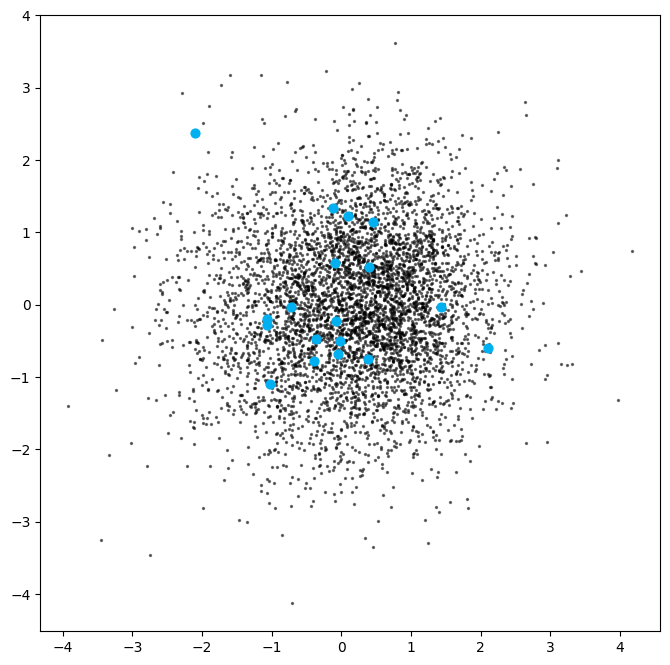

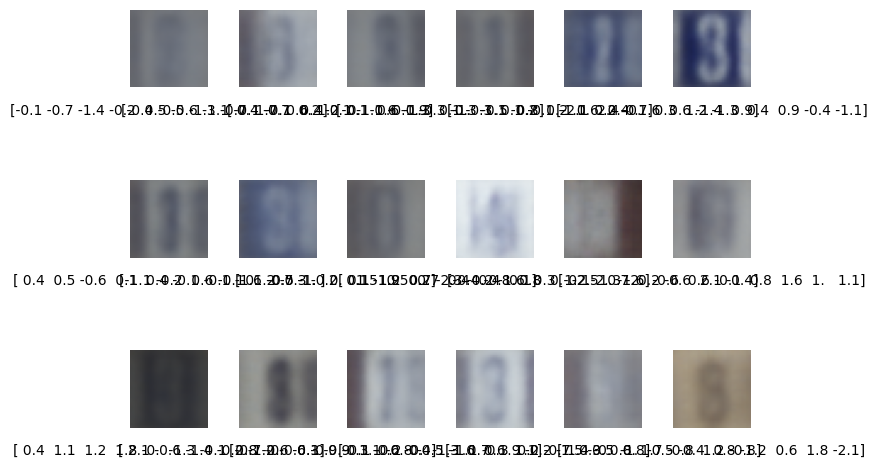

In [17]:
sample = norm.cdf(z_sample)
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Explore the latent space

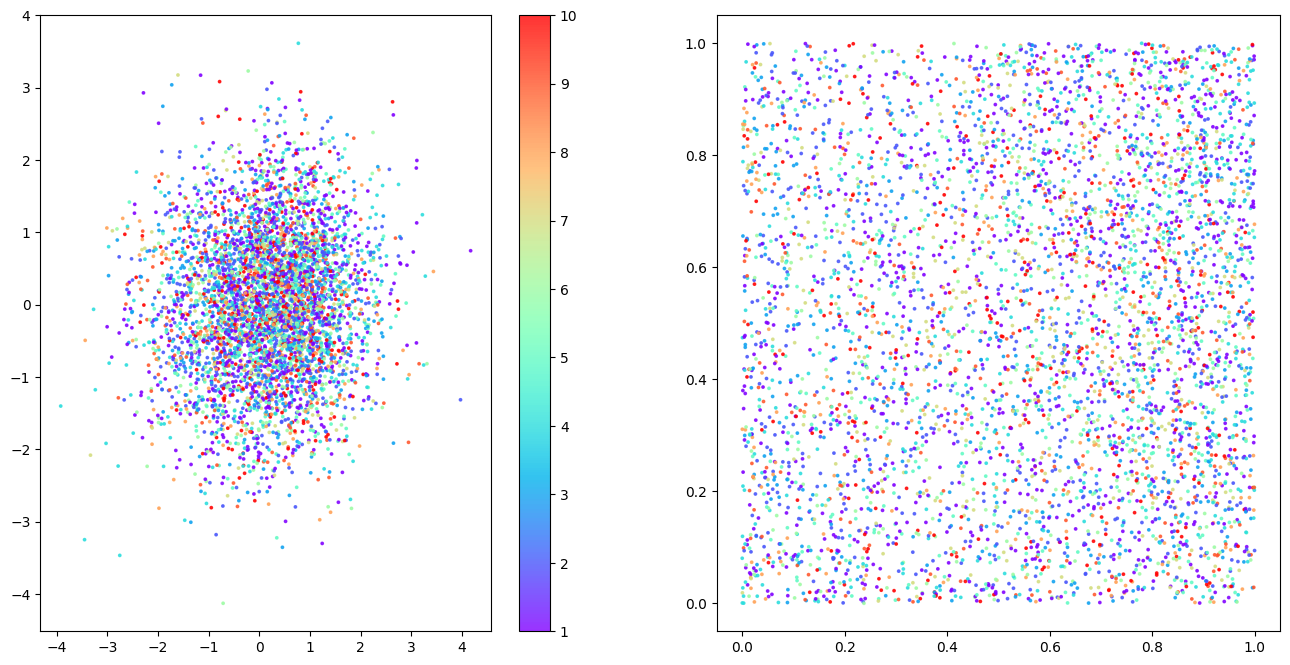

In [18]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

NameError: name 'decoder' is not defined

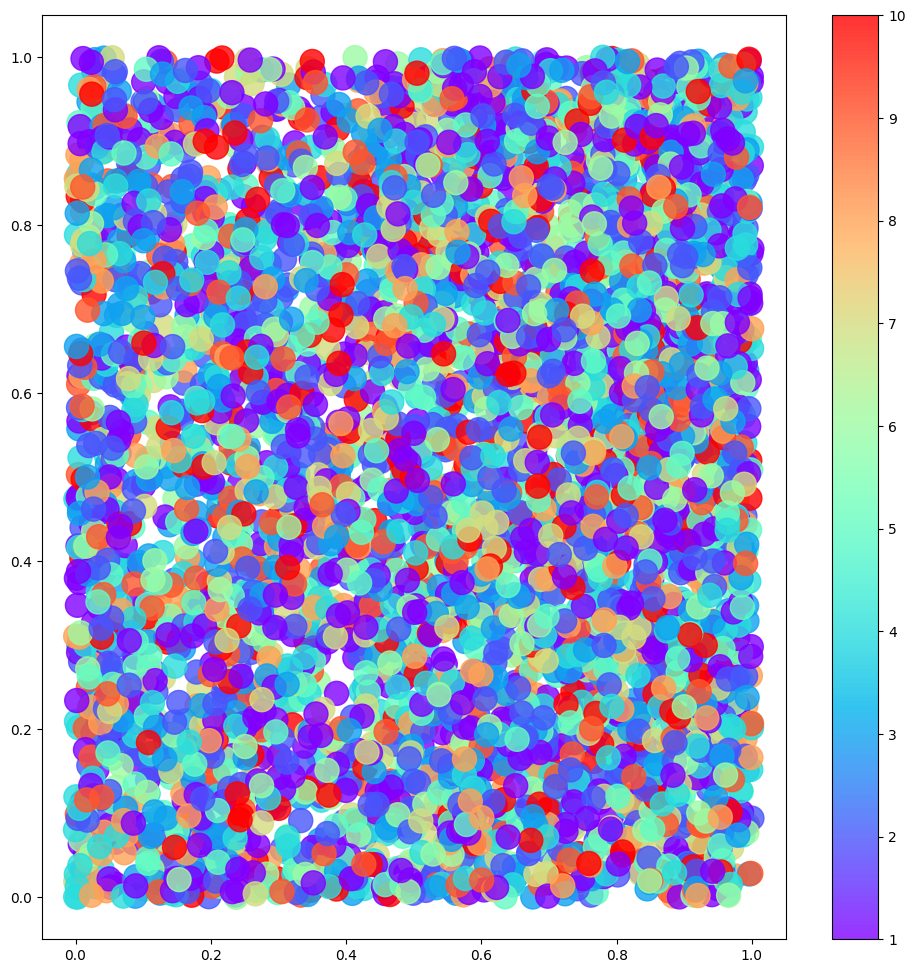

In [19]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")